In [7]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

# **1. Data loading and preprocessing**

In [8]:
# Get the images and captions path
image_data_location = "../input/flickr8k/Images"
caption_data_location = "../input/flickr8k/captions.txt"

In [5]:
df = pd.read_csv(caption_data_location)

In [5]:
# display first 5 lines of captions file
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [9]:
# Split data into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

**Display a sample image and its 5 respective captions:**

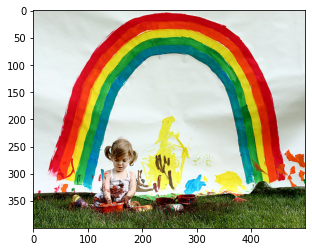

Caption - A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
Caption - A little girl is sitting in front of a large painted rainbow .
Caption - A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
Caption - There is a girl with pigtails sitting in front of a rainbow painting .
Caption - Young girl with pigtails painting outside in the grass .


In [22]:
data_idx = 11
image_path = image_data_location + "/" + df.iloc[data_idx,0]
# print( df.iloc[data_idx,:])
img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

for i in range(data_idx - 1, data_idx+5 - 1):
    print(f"Caption - {df.iloc[i,1]}")

In [10]:
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

**a sample of how each caption is tokenized:**

In [11]:
spacy_eng = spacy.load('en_core_web_sm')
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

Making the Vocabulary

# 2. Defining Vocabulary class:
**assign an index to each word in vocabulary and after tokenizing the captions, convert them to sequence of indexes.**

In [13]:
class Vocabulary:
    def __init__(self,freq_threshold):
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self,sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        tokenized_text = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]
                
                

In [14]:
v = Vocabulary(freq_threshold=1)
v.build_vocab(["This is a new city"])
print(v.stoi)
print(v.numericalize("This is a new city"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'new': 7, 'city': 8}
[4, 5, 6, 7, 8]


In [59]:
df = pd.read_csv(caption_data_location)
print(df["image"][0][::-1])

gpj.e0bc80b396_1028620001


# **3. Create a custom dataset class**

In [60]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        
        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [66]:
class Splitted_CustomDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.train_df = self.df[: int(0.8 * len(self.df))]
#         self.valid_df = self.df[int(0.8 * len(self.df)): int(0.9 * len(self.df))]
#         self.test_df = self.df[int(0.9 * len(self.df)):]
        
        self.transform = transform
        self.train_imgs = self.train_df["image"]
        self.train_captions = self.train_df["caption"]
        
#         self.valid_imgs = self.valid_df["image"]
#         self.valid_captions = self.valid_df["caption"]
        
#         self.test_imgs = self.test_df["image"]
#         self.test_captions = self.test_df["caption"]
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.train_captions.tolist())
                
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.train_captions[idx]
        img_name = self.train_imgs[idx]
        
        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [106]:
class Splitted_CustomDataset_valid(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
#         self.train_df = self.df[: int(0.8 * len(self.df))]
        self.valid_df = self.df[int(0.8 * len(self.df)): int(0.9 * len(self.df))]
#         self.test_df = self.df[int(0.9 * len(self.df)):]
        
        self.transform = transform
#         self.train_imgs = self.train_df["image"]
#         self.train_captions = self.train_df["caption"]
        
        self.valid_imgs = self.valid_df["image"]
        self.valid_captions = self.valid_df["caption"]
        
#         self.test_imgs = self.test_df["image"]
#         self.test_captions = self.test_df["caption"]
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.valid_captions.tolist())
                
    def __len__(self):
        return len(self.valid_df)
    
    def __getitem__(self, idx):
        caption = self.valid_captions[idx]
        img_name = self.valid_imgs[idx]
        
        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [94]:
class Splitted_CustomDataset_test(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
#         self.train_df = self.df[: int(0.8 * len(self.df))]
#         self.valid_df = self.df[int(0.8 * len(self.df)): int(0.9 * len(self.df))]
        self.test_df = self.df[int(0.9 * len(self.df)):]
        
        self.transform = transform
#         self.train_imgs = self.train_df["image"]
#         self.train_captions = self.train_df["caption"]
        
#         self.valid_imgs = self.valid_df["image"]
#         self.valid_captions = self.valid_df["caption"]
        
        self.test_imgs = self.test_df["image"]
        self.test_captions = self.test_df["caption"]
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.test_captions.tolist())
                
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.test_captions[idx]
        img_name = self.test_imgs[idx]
        
        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

**Define the transform to be applied**

In [47]:
#defining the transform to be applied
transforms = T.Compose([T.Resize((224,224)), T.ToTensor()])

**Define a function for displaying images:**

In [48]:
def show_image(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [73]:
# general dataset
# testing the dataset
dataset = CustomDataset(root_dir = image_data_location, captions_file = caption_data_location, transform = transforms)

In [67]:
# train dataset
train_ds = Splitted_CustomDataset(root_dir = image_data_location, captions_file = caption_data_location, transform = transforms)

In [107]:
# validation dataset
valid_ds = Splitted_CustomDataset_valid(root_dir = image_data_location, captions_file = caption_data_location, transform = transforms)

In [95]:
# test dataset
test_ds = Splitted_CustomDataset_test(root_dir = image_data_location, captions_file = caption_data_location, transform = transforms)

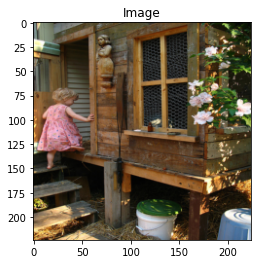

Token : tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence: 
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [53]:
img, caps = dataset[0]
# print(caps)
show_image(img,"Image")
print("Token :",caps)
print("Sentence: ")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [ ]:
class CapsCollate:
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
        
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
#         print(f"shape - {(imgs)}")
#         print("----"*22)
        imgs = torch.cat(imgs,dim=0)
#         print(f"shape - {imgs}")
#         print("------")
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [72]:
#writing the dataloader for general dataset
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]
# print(0.8*len(dataset))
data_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKER, shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True))

In [89]:
#writing the dataloader for train dataset
train_data_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKER, shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True))

In [108]:
#writing the dataloader for validation dataset
valid_data_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKER, shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True))

In [98]:
#writing the dataloader for test dataset
test_data_loader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKER, shuffle=True, collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True))

In [36]:
# train_loader = DataLoader(
#     dataset=train_dataset,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKER,
#     shuffle=True,
#     collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
# )

# val_loader = DataLoader(
#     dataset=val_dataset,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKER,
#     shuffle=True,
#     collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
# )

# test_loader = DataLoader(
#     dataset=test_dataset,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKER,
#     shuffle=False,
#     collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
# )

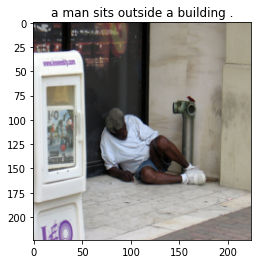

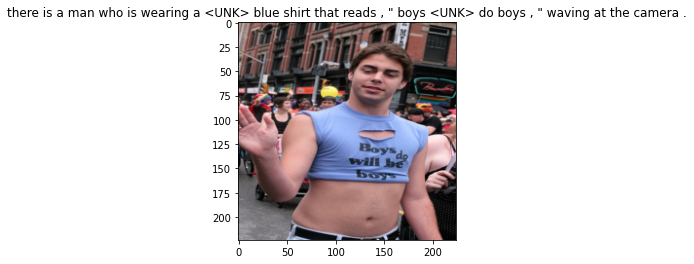

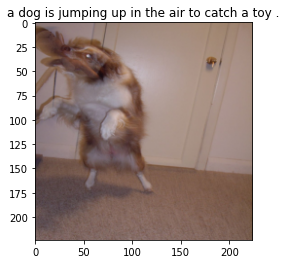

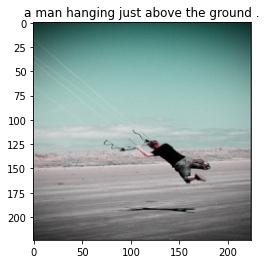

In [104]:
#generating the iterator from the general dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
#     print(f"captions - {captions[i]}")
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

In [ ]:
#generating the iterator from the train dataloader
dataiter = iter(train_data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
#     print(f"captions - {captions[i]}")
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

In [ ]:
#generating the iterator from the validation dataloader
dataiter = iter(valid_data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
#     print(f"captions - {captions[i]}")
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

In [ ]:
#generating the iterator from the test dataloader
dataiter = iter(test_data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
#     print(f"captions - {captions[i]}")
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

In [110]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# 4. Define the model:

**This model consists of 2 main parts:**
1.      The CNN model for feature extracting from images(Image decoding part)
1.      The LSTM model for generating caption out of embedded images and respective captions.**

In [ ]:
# vgg16 = models.resnet50(pretrained=True)
# for param in vgg16.parameters():
#     param.requires_grad_(False)
# modules = list(vgg16.children())[:-1]
# print(dir(vgg16))

# class EncoderCNN:
* **Apply feature extracting pretrained resnet18 model on images using forward method.**

class DecoderRNN:

 Apply decoding through embedded vectors of captions and images in the following order:
* embed caption
* concat caption and respective tensor of image features(output of resnet18)
* enter the concatenated tensor to the LSTM model
* enter the output of LSTM to a fully linear layer as final step 

**generate caption function:**

Given the image features generate the caption in a step by step manner in which it chooses the word with highest probability as output of each single state of LSTM model.

In [111]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN,self).__init__()
        resnet = models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features,embed_size)
        
    def forward(self,images):
        features = self.resnet(images)
#         print(f"resenet features shape - {features.shape}")
        features = features.view(features.size(0),-1)
#         print(f"resenet features viewed shape - {features.shape}")
        features = self.embed(features)
#         print(f"resenet features embed shape - {features.shape}")
        return features

class DecoderRNN(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(DecoderRNN,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self,features, captions):
        # vectorize the caption
#         print(f"captions - {captions[:,:-1]}")
#         print(f"caption shape - {captions[:,:-1].shape}")
        embeds = self.embedding(captions[:,:-1])
#         print(f"shape of embeds - {embeds.shape}")
        # concat the features and captions
#         print(f"features shape - {features.shape}")
#         print(f"features unsqueeze at index 1 shape - {features.unsqueeze(1).shape}")
        x = torch.cat((features.unsqueeze(1),embeds),dim=1)
#         print(f"shape of x - {x.shape}")
        x,_ = self.lstm(x)
#         print(f"shape of x after lstm - {x.shape}")
        x = self.fcn(x)
#         print(f"shape of x after fcn - {x.shape}")
        return x
    
    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = inputs.size(0)
        
        captions = []
        
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]


class EncoderDecoder(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(EncoderDecoder,self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs
# resenet features shape - torch.Size([4, 2048, 1, 1])
# resenet features viewed shape - torch.Size([4, 2048])
# resenet features embed shape - torch.Size([4, 400])
# caption shape - torch.Size([4, 14])
# shape of embeds - torch.Size([4, 14, 400])
# features shape - torch.Size([4, 400])
# features unsqueeze at index 1 shape - torch.Size([4, 1, 400])
# shape of x - torch.Size([4, 15, 400])
# shape of x after lstm - torch.Size([4, 15, 512])
# shape of x after fcn - torch.Size([4, 15, 2994])

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Tunning hyper parameters

the hyperparameters are selected as mentioned in project document.

In [113]:
# Hyperparameters
embed_size = 300
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 0.0001
# num_epochs = 2

In [114]:
# initialize model, loss etc
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# Training phase

In [128]:
num_epochs = 20
print_every = 2000
model.train()

# Initialize a list to store the losses
epoch_losses = []
acc_loss = 0

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device), captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        
        # Accumulate the loss
        acc_loss += loss.item()
        
        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
        
        # Calculate and store the average loss for the epoch
        epoch_loss = acc_loss / len(data_loader)
        epoch_losses.append(epoch_loss)
                


Epoch: 1 loss: 2.35070
Epoch: 1 loss: 1.88983
Epoch: 1 loss: 2.80361
Epoch: 1 loss: 2.12753
Epoch: 1 loss: 2.02661
Epoch: 2 loss: 1.70852
Epoch: 2 loss: 2.08224
Epoch: 2 loss: 1.66796
Epoch: 2 loss: 1.80409
Epoch: 2 loss: 2.06568
Epoch: 3 loss: 2.02541
Epoch: 3 loss: 2.20290
Epoch: 3 loss: 1.97915
Epoch: 3 loss: 1.87386
Epoch: 3 loss: 2.25794
Epoch: 4 loss: 1.71903
Epoch: 4 loss: 1.82279
Epoch: 4 loss: 1.67182
Epoch: 4 loss: 2.80029
Epoch: 4 loss: 1.80547
Epoch: 5 loss: 2.19220
Epoch: 5 loss: 2.02631
Epoch: 5 loss: 1.62754
Epoch: 5 loss: 1.57046
Epoch: 5 loss: 1.45554
Epoch: 6 loss: 1.73863
Epoch: 6 loss: 1.96781
Epoch: 6 loss: 1.93788
Epoch: 6 loss: 1.90704
Epoch: 6 loss: 2.18923
Epoch: 7 loss: 2.05467
Epoch: 7 loss: 2.12300
Epoch: 7 loss: 1.84257
Epoch: 7 loss: 1.93650
Epoch: 7 loss: 2.21198
Epoch: 8 loss: 1.79503
Epoch: 8 loss: 2.24624
Epoch: 8 loss: 1.84340
Epoch: 8 loss: 2.16104
Epoch: 8 loss: 1.85278
Epoch: 9 loss: 1.60955
Epoch: 9 loss: 1.46718
Epoch: 9 loss: 2.30664
Epoch: 9 lo

# Evaluating the model

<SOS> a brown dog is running through the water . <EOS>


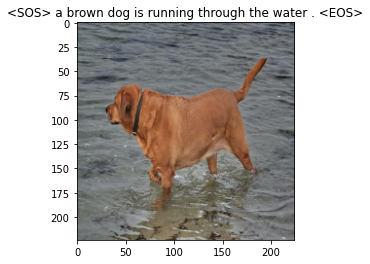

<SOS> a man is standing on a dock near the water . <EOS>


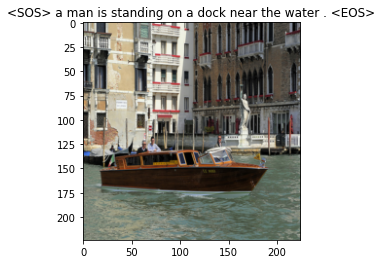

<SOS> a group of people are standing in front of a <UNK> building . <EOS>


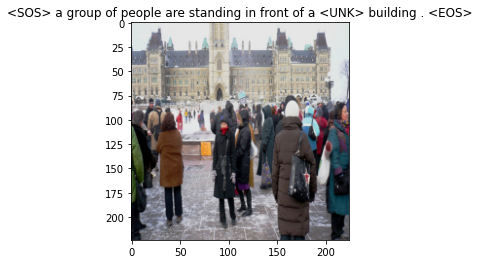

In [130]:
#generate the caption
model.eval()
cnt = 0
for idx, (image, captions) in enumerate(iter(data_loader)):
    if cnt == 3:
        break
    with torch.no_grad():
        dataiter = iter(data_loader)
        img,_ = next(dataiter)
        features = model.encoder(img[0:1].to(device))
#         print(f"features shape - {features.shape}")
        caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
        caption = ' '.join(caps)
        print(caption)
        show_image(img[0],title=caption)
        cnt += 1